In [527]:
#utilities
import re
import pickle
import numpy as np
import pandas as pd
#plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
#nltk
import nltk
from nltk.stem import WordNetLemmatizer
#sklearn
from sklearn import metrics
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

## Importing and cleaning data

In [429]:
#removing encoding and naming columns
data_columns = ['sentiment','ids','date','flag','user','tweet']
data_encoding = 'ISO-8859-1'
dataset = pd.read_csv('../../../../../Downloads/training.1600000.processed.noemoticon.csv',encoding=data_encoding,names=data_columns)
dataset_columns_sm = ['tweet','brand','sentiment']
dataset_encoding_sm = 'latin1'
dataset_sm = pd.read_csv('../../../../../Downloads/judge-1377884607_tweet_product_company.csv', encoding = dataset_encoding_sm, names=dataset_columns_sm)

In [430]:
dataset.head()

,sentiment,ids,date,flag,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [431]:
dataset_sm.head()

,tweet,brand,sentiment
0,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_pro...
1,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
2,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
3,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
4,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion


In [432]:
x = dataset_sm[dataset_sm['sentiment'] == 'No emotion toward brand or product'].index

In [433]:
y = dataset_sm[dataset_sm['sentiment'] == "I can't tell"].index

In [434]:
z = dataset_sm[dataset_sm['sentiment'] == "is_there_an_emotion_directed_at_a_brand_or_product"].index

In [436]:
# dataset_sm.drop(x, inplace = True)
# dataset_sm.drop(y, inplace = True)
# dataset_sm.drop(z, inplace = True)

In [437]:
dataset_sm.describe

<bound method NDFrame.describe of                                                   tweet  \
1     .@wesley83 I have a 3G iPhone. After 3 hrs twe...   
2     @jessedee Know about @fludapp ? Awesome iPad/i...   
3     @swonderlin Can not wait for #iPad 2 also. The...   
4     @sxsw I hope this year's festival isn't as cra...   
5     @sxtxstate great stuff on Fri #SXSW: Marissa M...   
...                                                 ...   
9078  @mention your PR guy just convinced me to swit...   
9080  &quot;papyrus...sort of like the ipad&quot; - ...   
9081  Diller says Google TV &quot;might be run over ...   
9086  I've always used Camera+ for my iPhone b/c it ...   
9089                      Ipad everywhere. #SXSW {link}   

                                brand         sentiment  
1                              iPhone  Negative emotion  
2                  iPad or iPhone App  Positive emotion  
3                                iPad  Positive emotion  
4                  iPad o

In [439]:
dataset.describe

<bound method NDFrame.describe of          sentiment         ids                          date      flag  \
0                0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1                0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2                0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3                0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4                0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
...            ...         ...                           ...       ...   
1599995          4  2193601966  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599996          4  2193601969  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599997          4  2193601991  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599998          4  2193602064  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599999          4  2193602129  Tue Jun 16 08:40:50 PDT 2009  NO_QUERY   

                    user                                              tweet  

In [440]:
# dataset = dataset.iloc[::5,:]
# dataset = dataset.iloc[::5,:]
# dataset = dataset.iloc[::5,:]

In [441]:
dataset.sentiment.value_counts()

4    6400
0    6400
Name: sentiment, dtype: int64

In [443]:
#removing undesired columns
dataset = dataset[['sentiment','tweet']]
#replacing 4 with 1 for easier understanding
dataset['sentiment'] = dataset['sentiment'].replace(4,1)


/Users/kelvinarellano/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [445]:
import spacy 
from spacy import displacy

In [12]:
#!python -m spacy download en_core_web_lg

In [446]:
nlp = spacy.load('en_core_web_lg')

In [447]:
#text = dataset['text'].str.cat(sep=' ')
dataset = dataset.set_index(np.arange(0,12800))

In [448]:
def explain_text_entities(dataset_column):
    tag_list = []
    noun_list = []
    for index, value in dataset_column.items():
        value_tags = []
        nouns = []
        doc = nlp(value)
        for ent in doc.ents:
            value_tags.append(ent.label_)
        for chunk in doc.noun_chunks:
            nouns.append([chunk.root.text, chunk.root.dep_])
        tag_list.append(value_tags)
        noun_list.append(nouns)
    dataset['tags'] = tag_list
    dataset['nouns'] = noun_list
    
#     return new_dataset
#         doc = nlp(text)
#     for ent in doc.ents:
#         print(f'Entity: {ent}, Label: {ent.label_}, {spacy.explain(ent.label_)}')

In [450]:
dataset_1 = dataset['tweet']
#dataset_1 = dataset_1[:5]
explain_text_entities(dataset_1)

In [451]:
dataset

,sentiment,tweet,tags,nouns
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",[PERSON],"[[http://twitpic.com/2y1zl, ROOT], [bummer, at..."
1,0,@allyheman but.. but.. but.. I'm not a big fan...,[],"[[@allyheman, ROOT], [I, nsubj], [fan, attr], ..."
2,0,New video card is DOA.,[ORG],"[[card, nsubj], [DOA, attr]]"
3,0,"STOU site not update, no info about 2/2552 exa...",[ORG],"[[site, nsubj], [info, dobj], [exam, pobj], [c..."
4,0,@Anistorm Sorry,[],[]
...,...,...,...,...
12795,1,"doggy likes to play with the vacuum cleaner, d...",[],"[[likes, nsubj], [cleaner, pobj], [it, nsubj],..."
12796,1,Sitting in a meeting with my mom &amp; grandmo...,[],"[[meeting, pobj], [mom, pobj], [amp, conj], [g..."
12797,1,"@gloomybread aha, thankyou",[],[]
12798,1,@jerseyshorejen haha I know that's why I said ...,[PRODUCT],"[[I, nsubj], [I, nsubj], [I, nsubj], [Comcast,..."


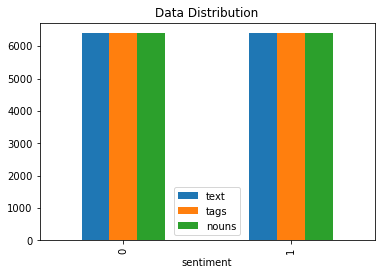

In [428]:
ax = dataset.groupby('sentiment').count().plot(kind='bar',title='Data Distribution')


In [466]:
full_dataset = pd.concat([dataset,dataset_sm], axis = 0)

/Users/kelvinarellano/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [470]:
full_dataset['sentiment'] = dataset['sentiment'].replace('Positive emotion',1)
full_dataset['sentiment'] = dataset['sentiment'].replace('Negative emotion',0)
full_dataset

,brand,nouns,sentiment,tags,tweet
0,NaN,"[[http://twitpic.com/2y1zl, ROOT], [bummer, at...",0,[PERSON],"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,NaN,"[[@allyheman, ROOT], [I, nsubj], [fan, attr], ...",0,[],@allyheman but.. but.. but.. I'm not a big fan...
2,NaN,"[[card, nsubj], [DOA, attr]]",0,[ORG],New video card is DOA.
3,NaN,"[[site, nsubj], [info, dobj], [exam, pobj], [c...",0,[ORG],"STOU site not update, no info about 2/2552 exa..."
4,NaN,[],0,[],@Anistorm Sorry
...,...,...,...,...,...
9078,iPhone,NaN,1,NaN,@mention your PR guy just convinced me to swit...
9080,iPad,NaN,1,NaN,&quot;papyrus...sort of like the ipad&quot; - ...
9081,Other Google product or service,NaN,1,NaN,Diller says Google TV &quot;might be run over ...
9086,iPad or iPhone App,NaN,1,NaN,I've always used Camera+ for my iPhone b/c it ...


In [484]:
len(full_dataset)

16348

In [477]:
#seperating text and sentiment into itterable list
text, sentiment = list(full_dataset['tweet']),list(full_dataset['sentiment'])  


In [546]:
negative =  full_dataset.loc[(full_dataset['sentiment'] == 0)]

In [548]:
positive = full_dataset.loc[(full_dataset['sentiment'] == 1)]

In [549]:
positive_text,negative_text = list(positive['tweet']),list(negative['tweet'])

In [478]:
#replacing emojis with text equivelent
emojis = {':)':'smile',':-)':'smile',':d':'wink',':-E':'vampire',':(':'sad',':-(': 'sad', ':-<': 'sad',
          ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}


#creating more robust stopwords list
stop_word_list = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']


In [563]:
def preprocess(textdata):
    #empty list to return after processing is done
    processed_text = []
    
    #instance of lemmatizer
    word_lemmatizer = WordNetLemmatizer()
    
    #regex patterns
    url_pattern = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
    user_pattern = '@[^\s]+'
    alpha_numeric_pattern = '[^a-zA-Z0-9]'
    repeating_character_pattern = r'(.)\1\1+'
    replace_repeat_char = 'r\1\1'
    
    #looping through eacg tweet
    for tweet in textdata:
        
        #making the tweet lower case
        tweet = tweet.lower()
        
        #replacing all emojis
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, 'EMOJI'+emojis[emoji])
        
        #replacing all urls
        tweet = re.sub(url_pattern, 'URL',tweet)
        
        #replacing all usernames
        tweet = re.sub(user_pattern, 'USER',tweet)
        
        #replacing all non alphanumeric values
        tweet = re.sub(alpha_numeric_pattern, ' ', tweet)
        
        #replace all repeating characters
        tweet  = re.sub(repeating_character_pattern, replace_repeat_char, tweet)
        
        tweet_words = ''
        for word in tweet.split():
            if word not in stop_word_list:
                if word != 'USER':
                    if word != 'URL':
                        if len(word)>1:
                            word = word_lemmatizer.lemmatize(word)
                            tweet_words += (word+' ')
        processed_text.append(tweet_words)
    return processed_text

In [480]:
import time
t = time.time()
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken:{round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken:1 seconds


In [564]:
t = time.time()
processedtext_positive = preprocess(positive_text)
print(f'Text Preprocessing complete.')
print(f'Time Taken:{round(time.time()-t)} seconds')
processedtext_negative = preprocess(negative_text)
print(f'Text Preprocessing complete.')
print(f'Time Taken:{round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken:1 seconds
Text Preprocessing complete.
Time Taken:2 seconds


In [540]:
processedtext

['USER URLr\x01\x01ar\x01\x01 bummerr\x01\x01you shoulda got david carr third day itr\x01\x01d ',
 'USER butr\x01\x01butr\x01\x01butr\x01\x01i not big fan camilla belle ',
 'new video card doa ',
 'stou site not update no info 2552 exam open course must wait mail notice doc umr\x01\x01 ',
 'USER sorry ',
 'USER april 9th isn coming soon enough ',
 'USER coolr\x01\x01i no tweet apps razr ',
 'no lost loyal ',
 'USER USER um would hell no fugly poker dog pant cruiser\x01\x01hi jonathan sorry missed ',
 'USER aww moe planning leaving tomorrow evening gonna town chance ',
 'USER run great thanks windy today bike ride not option morning ',
 'believe got answer didn ask questionr\x01\x01this feel awful ',
 'sr\x01\x01 tiredr\x01\x01work ',
 'keep working place don cycle2work scheme 15 disc halfauds good enough ',
 'think factorial design going death test quot quotr\x01\x01who come confusing quot mathy quot stuffr\x01\x01ugh ',
 'off doctor today emily rash look like measles ',
 'morning twit

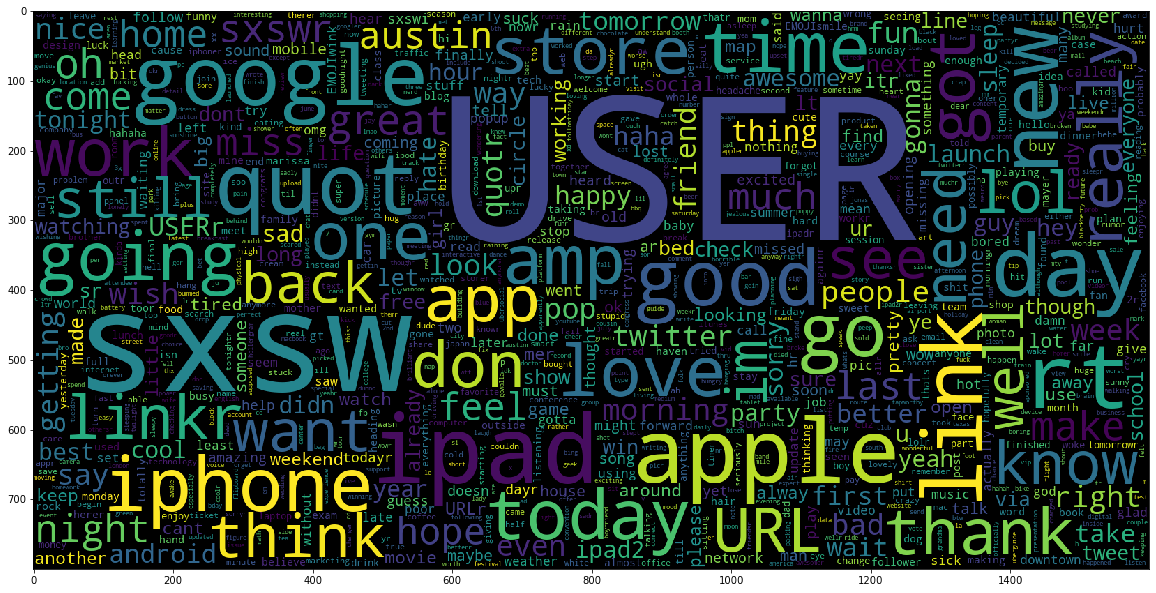

In [483]:
#make one for negative and positive
data = processedtext[:16348]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data))
plt.imshow(wc)

In [565]:
len(processedtext_negative)

8953

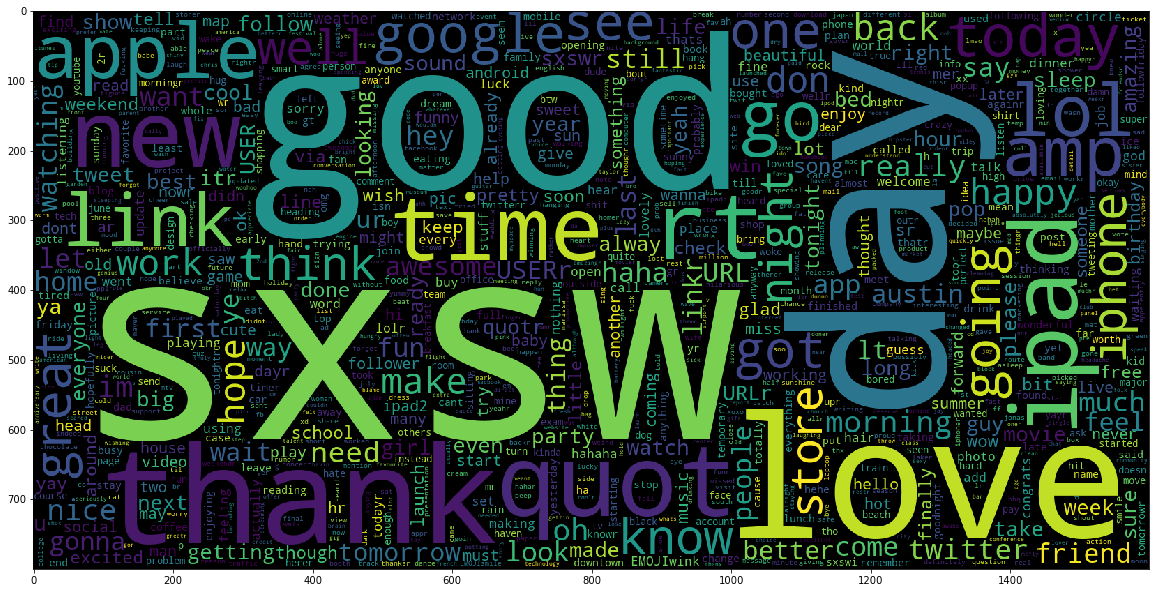

In [566]:
#positive word cloud
data_positive = processedtext_positive[:7395]
plt.figure(figsize = (20,20))
wc_positive = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_positive))
plt.imshow(wc_positive)

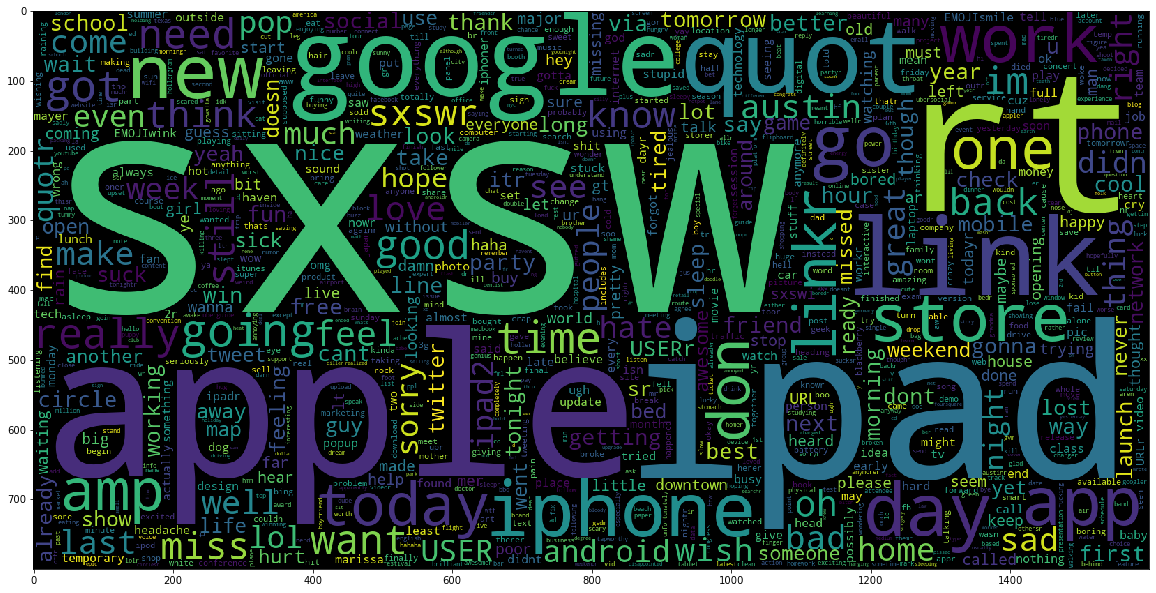

In [567]:
#negative wordcloud
data_negative = processedtext_negative[:8953]
plt.figure(figsize = (20,20))
wc_negative = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_negative))
plt.imshow(wc_negative)

In [485]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment,
                                                    test_size = 0.2, random_state = 0)
print(f'Data Split done.')

Data Split done.


In [486]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=20000)
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

Vectoriser fitted.
No. of feature_words:  20000


In [487]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


In [488]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

           0       0.74      0.71      0.72      1741
           1       0.68      0.72      0.70      1529

    accuracy                           0.71      3270
   macro avg       0.71      0.71      0.71      3270
weighted avg       0.71      0.71      0.71      3270



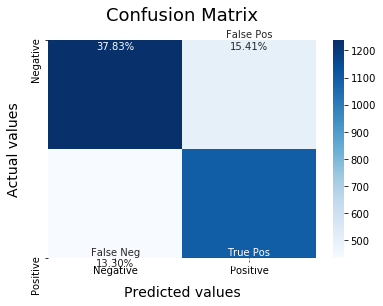

In [489]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

              precision    recall  f1-score   support

           0       0.73      0.76      0.74      1741
           1       0.71      0.68      0.69      1529

    accuracy                           0.72      3270
   macro avg       0.72      0.72      0.72      3270
weighted avg       0.72      0.72      0.72      3270



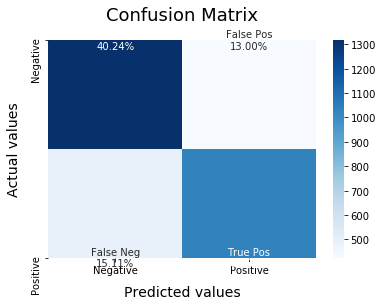

In [490]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)

/Users/kelvinarellano/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.73      0.80      0.76      1741
           1       0.74      0.66      0.70      1529

    accuracy                           0.73      3270
   macro avg       0.74      0.73      0.73      3270
weighted avg       0.74      0.73      0.73      3270



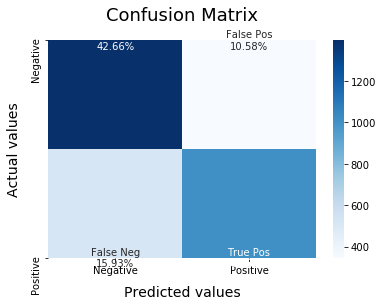

In [520]:
LRmodel = LogisticRegression(C = 1, max_iter = 10, n_jobs=-1, solver='sag',penalty='l2')
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)

In [492]:
from sklearn.model_selection import KFold,RepeatedStratifiedKFold,GridSearchCV,cross_val_score


In [498]:
from sklearn.svm import SVC

svc = SVC(random_state=0)
svc.fit(X_train, y_train)

SVC(random_state=0)

In [518]:
param_grid_Log = {'C':[1.0,10.0,100.0,1000.0],'max_iter':[1,10,100,1000], 'solver':['lbfgs','liblinear','sag','saga'], 'penalty':['l1','l2','elasticnet']}
grid_Log = GridSearchCV(estimator = LogisticRegression(),
                        param_grid=param_grid_Log,
                        scoring='accuracy',
                        verbose=1,
                        n_jobs=-1
                        )
result_grid_Log = grid_Log.fit(X_train, y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 33.0min
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed: 80.7min finished
/Users/kelvinarellano/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [519]:
result_grid_Log.best_params_

{'C': 1.0, 'max_iter': 10, 'penalty': 'l2', 'solver': 'sag'}

In [499]:
param_grid_SVC = {'C':[1,10,100,1000],'max_iter':[1,10,100,1000], solver:['sag','saga'], penalty:[12,'elasticnet']}

grid_SVC = GridSearchCV(estimator=SVC(),
                    param_grid=param_grid_SVC,
                    scoring='accuracy',
                    verbose=1,
                    n_jobs=-1)

result_grid_SVC = grid_SVC.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 44.2min finished


In [500]:
result_grid_SVC.best_params_

{'C': 1, 'gamma': 1, 'kernel': 'rbf'}

In [505]:

SVC_tuned = SVC()
SVC_tuned = SVC(gamma=1, C=1, kernel='rbf')
SVC_tuned.fit(X_train, y_train)


y_pred_SVC_tuned = svc.predict(X_test)

              precision    recall  f1-score   support

           0       0.73      0.80      0.76      1741
           1       0.75      0.66      0.70      1529

    accuracy                           0.74      3270
   macro avg       0.74      0.73      0.73      3270
weighted avg       0.74      0.74      0.74      3270



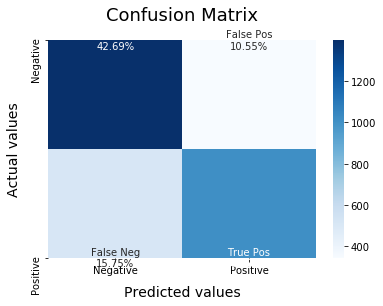

In [506]:
model_Evaluate(SVC_tuned)

In [539]:

# performing the roc curve calculations
fpr, tpr, thresholds = metrics.roc_curve(X_train, y_train)

# Printing the Area Under Curve (AUC) of the ROC curve (the closer to 1, the better)
auc = metrics.roc_auc_score(X_train,y_train)
print('AUC: %.3f' % auc)

TypeError: len() of unsized object

In [ ]:
LogisticRegression

things to look into:

lstmu
gru
transformers
how to preprocess data for rnn
embeding layer
lda
tsney
count plot for positive and negative

tweet dimentionality reduction tesne

rnn 